In [2]:
import nibabel as nib
import nilearn as nil
import numpy as np
import pandas as pd
import os
import os.path
from nilearn import plotting, image
from nipype.interfaces.spm import TwoSampleTTestDesign, EstimateModel, EstimateContrast, Threshold, MultipleRegressionDesign
from nipype.pipeline.engine import Workflow, Node, MapNode
import sys
sys.path.append('..')
from src.utils.data import getDataPandas, getPandas, getConfig
os.chdir('..')

In [3]:
hc = getPandas('hc_data')
age_list = hc['AGE'].tolist()
img_list = hc['CAT12_SGM']
img_list = img_list.apply(os.path.abspath).tolist()

In [8]:
wf = Workflow(name='agecorrection', base_dir='tmp')

mr = Node(MultipleRegressionDesign(), name='mr')
mr.inputs.in_files = img_list
mr.inputs.include_intercept = True
mr.inputs.user_covariates = [
    {'name': 'age', 'vector': age_list}
]

model = Node(EstimateModel(), name='model')
model.inputs.estimation_method = {'Classical': 1}
#model.inputs.use_implicit_threshold = True

contrast = Node(EstimateContrast(), name='contrast')
con = ('age','T', ['age'],[1])
contrast.inputs.contrasts = [con]
contrast.inputs.group_contrast = True

threshold = Node(Threshold(
    contrast_index=1,
    use_topo_fdr=False,
    use_fwe_correction=False,
    extent_threshold=5,
    height_threshold=0.05,
    height_threshold_type='p-value',
    extent_fdr_p_threshold=0.05), name='thres')

wf.connect([
    (mr, model, [('spm_mat_file', 'spm_mat_file')]),
    (model, contrast, [('spm_mat_file', 'spm_mat_file'),
                        ('beta_images', 'beta_images'),
                        ('residual_image', 'residual_image')]),
    (contrast, threshold, [('spm_mat_file', 'spm_mat_file'),
                            ('spmT_images', 'stat_image')]),
])

wf.run()

230416-16:13:30,832 nipype.workflow INFO:
	 Workflow agecorrection settings: ['check', 'execution', 'logging', 'monitoring']
230416-16:13:30,839 nipype.workflow INFO:
	 Running serially.
230416-16:13:30,840 nipype.workflow INFO:
	 [Node] Setting-up "agecorrection.mr" in "/home/biobot/disk/ldopa/tmp/agecorrection/mr".
230416-16:13:30,844 nipype.workflow INFO:
	 [Node] Cached "agecorrection.mr" - collecting precomputed outputs
230416-16:13:30,845 nipype.workflow INFO:
	 [Node] "agecorrection.mr" found cached.
230416-16:13:30,845 nipype.workflow INFO:
	 [Node] Setting-up "agecorrection.model" in "/home/biobot/disk/ldopa/tmp/agecorrection/model".
230416-16:13:30,847 nipype.workflow INFO:
	 [Node] Cached "agecorrection.model" - collecting precomputed outputs
230416-16:13:30,847 nipype.workflow INFO:
	 [Node] "agecorrection.model" found cached.
230416-16:13:30,847 nipype.workflow INFO:
	 [Node] Setting-up "agecorrection.contrast" in "/home/biobot/disk/ldopa/tmp/agecorrection/contrast".
23041

stty: 标准输入: 对设备不适当的 ioctl 操作


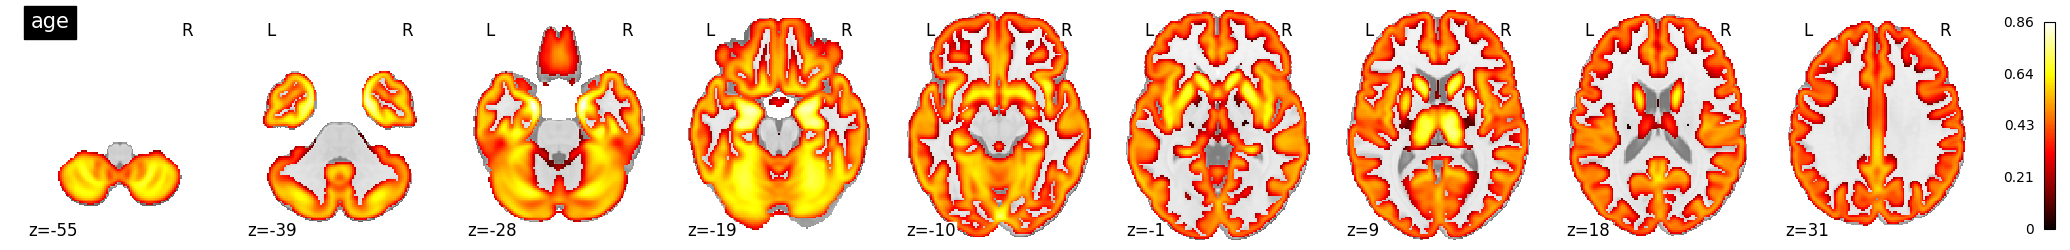

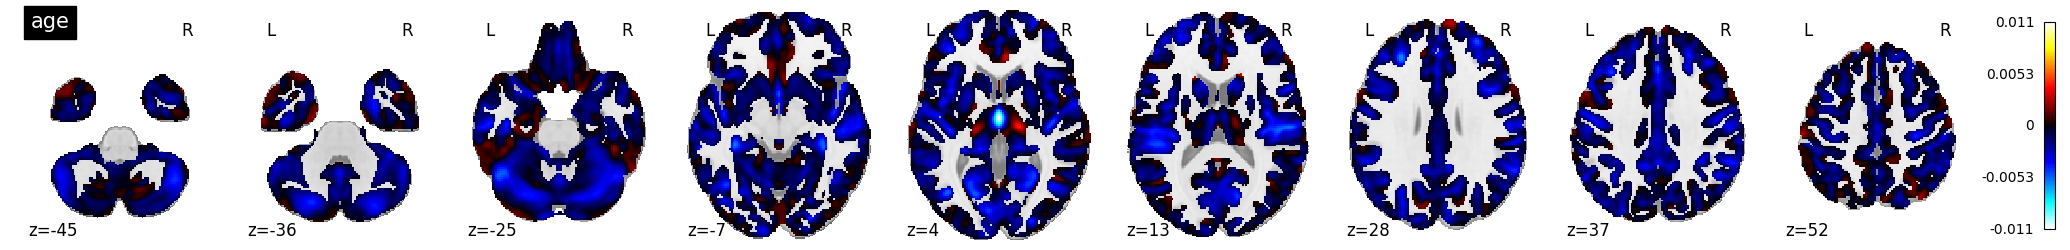

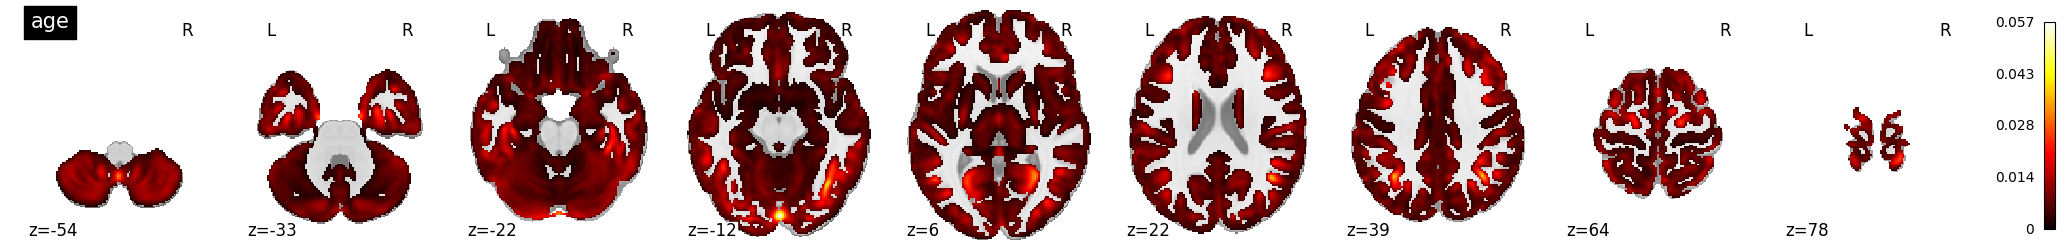

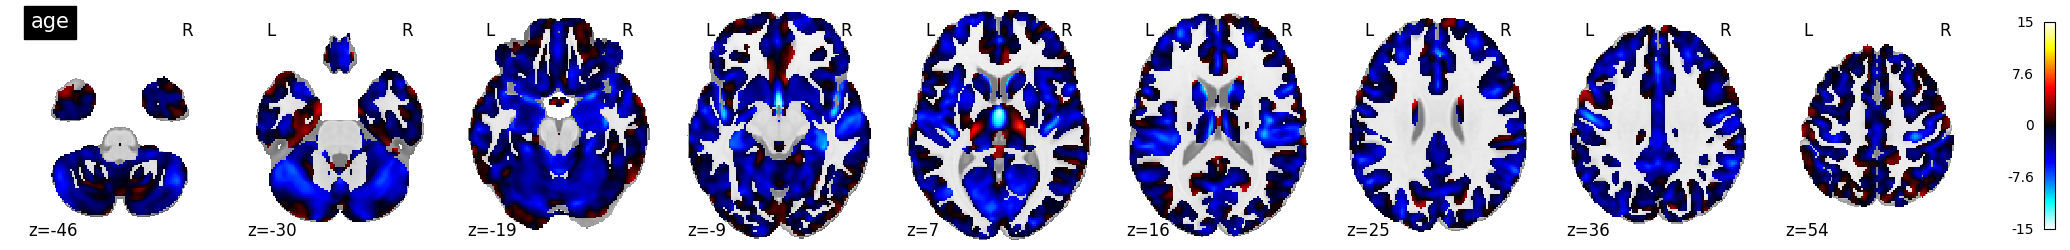

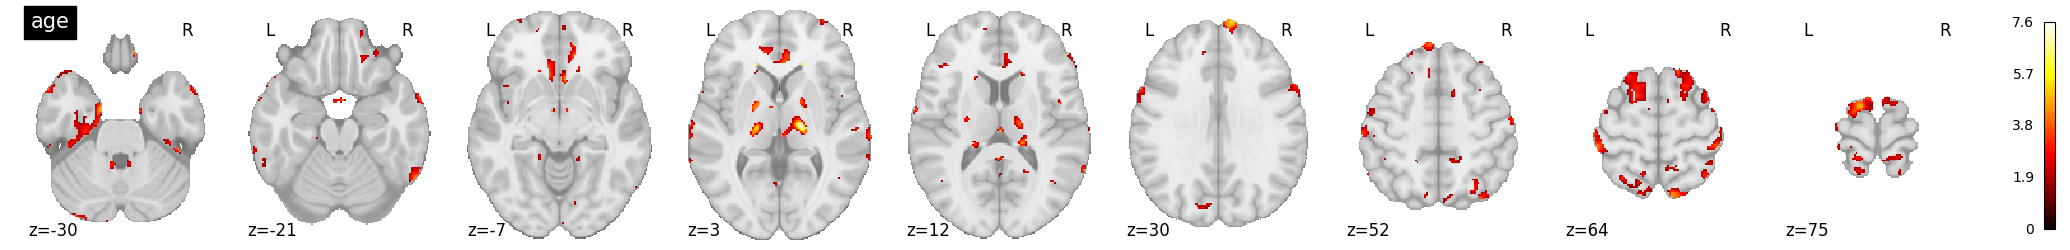

In [9]:
from nilearn import plotting, image
import matplotlib.pyplot as plt
plotting.plot_stat_map('tmp/agecorrection/model/beta_0001.nii', display_mode='z', cut_coords=9, title='age')
plt.show()
plotting.plot_stat_map('tmp/agecorrection/model/beta_0002.nii', display_mode='z', cut_coords=9, title='age')
plt.show()
plotting.plot_stat_map('tmp/agecorrection/model/ResMS.nii', display_mode='z', cut_coords=9, title='age')
plt.show()
plotting.plot_stat_map('tmp/agecorrection/contrast/spmT_0001.nii', display_mode='z', cut_coords=9, title='age')
plt.show()
plotting.plot_stat_map('tmp/agecorrection/thres/spmT_0001_thr.nii', display_mode='z', cut_coords=9, title='age')
plt.show()

In [11]:
data = getPandas('pat_data')
data_config = getConfig('data')
train_inds = data_config['indices']['pat']['train']
test_inds = data_config['indices']['pat']['test']
data_train = data.iloc[train_inds].reset_index(drop=True)
data_test = data.iloc[test_inds].reset_index(drop=True)
data_full = data.iloc[train_inds + test_inds].reset_index(drop=True)

In [13]:
train_good = data_train[data_train['CAT_MDS']==1]
train_bad = data_train[data_train['CAT_MDS']==0]
#train_good = data_full[data_full['CAT']==1]
#train_bad = data_full[data_full['CAT']==0]
img_good = train_good['CAT12_SGM']
img_bad = train_bad['CAT12_SGM']
img_good = img_good.apply(os.path.abspath)
img_bad = img_bad.apply(os.path.abspath)

In [14]:
age_good = train_good['AGE']
age_bad = train_bad['AGE']
sex_good = train_good['SEX']
sex_bad = train_bad['SEX']
agelist = age_good.tolist() + age_bad.tolist()
sexlist = sex_good.tolist() + sex_bad.tolist()

In [15]:
wf = Workflow(name='voxelwise', base_dir='tmp')

ttest = Node(TwoSampleTTestDesign(), name='ttest')
ttest.inputs.group1_files = img_good.tolist()
ttest.inputs.group2_files = img_bad.tolist()
ttest.inputs.covariates = [
    {'name': 'age', 'vector': agelist},
    {'name': 'sex', 'vector': sexlist},
]

model = Node(EstimateModel(), name='model')
model.inputs.estimation_method = {'Classical': 1}

contrast = Node(EstimateContrast(), name='contrast')
con1 = ('good>bad','T', ['Group_{1}','Group_{2}'],[1,-1])
con2 = ('bad>good','T', ['Group_{1}','Group_{2}'],[-1,1])
con_list = [con1, con2]
contrast.inputs.contrasts = con_list
contrast.inputs.group_contrast = True

threshold = MapNode(Threshold(
    contrast_index=1,
    use_topo_fdr=True,
    use_fwe_correction=False,
    extent_threshold=0,
    height_threshold=0.05,
    height_threshold_type='p-value',
    extent_fdr_p_threshold=0.05), name='thres', iterfield=['stat_image'])

wf.connect([
    (ttest, model, [('spm_mat_file', 'spm_mat_file')]),
    (model, contrast, [('spm_mat_file', 'spm_mat_file'), ('beta_images', 'beta_images'), ('residual_image', 'residual_image')]),
    (contrast, threshold, [('spm_mat_file', 'spm_mat_file'), ('spmT_images', 'stat_image')])
])

wf.run()

230416-16:18:30,21 nipype.workflow INFO:
	 Workflow voxelwise settings: ['check', 'execution', 'logging', 'monitoring']
230416-16:18:30,35 nipype.workflow INFO:
	 Running serially.
230416-16:18:30,36 nipype.workflow INFO:
	 [Node] Setting-up "voxelwise.ttest" in "/home/biobot/disk/ldopa/tmp/voxelwise/ttest".
230416-16:18:30,40 nipype.workflow INFO:
	 [Node] Outdated cache found for "voxelwise.ttest".
230416-16:18:30,48 nipype.workflow INFO:
	 [Node] Executing "ttest" <nipype.interfaces.spm.model.TwoSampleTTestDesign>
230416-16:18:41,37 nipype.workflow INFO:
	 [Node] Finished "ttest", elapsed time 10.987501s.
230416-16:18:41,40 nipype.workflow INFO:
	 [Node] Setting-up "voxelwise.model" in "/home/biobot/disk/ldopa/tmp/voxelwise/model".
230416-16:18:41,42 nipype.workflow INFO:
	 [Node] Outdated cache found for "voxelwise.model".
230416-16:18:41,44 nipype.workflow INFO:
	 [Node] Executing "model" <nipype.interfaces.spm.model.EstimateModel>


stty: 标准输入: 对设备不适当的 ioctl 操作


230416-16:19:13,703 nipype.workflow INFO:
	 [Node] Finished "model", elapsed time 32.657847s.
230416-16:19:13,707 nipype.workflow INFO:
	 [Node] Setting-up "voxelwise.contrast" in "/home/biobot/disk/ldopa/tmp/voxelwise/contrast".
230416-16:19:13,709 nipype.workflow INFO:
	 [Node] Outdated cache found for "voxelwise.contrast".
230416-16:19:13,714 nipype.workflow INFO:
	 [Node] Executing "contrast" <nipype.interfaces.spm.model.EstimateContrast>


stty: 标准输入: 对设备不适当的 ioctl 操作


230416-16:19:24,943 nipype.workflow INFO:
	 [Node] Finished "contrast", elapsed time 11.227369s.
230416-16:19:24,948 nipype.workflow INFO:
	 [Node] Outdated cache found for "voxelwise.thres".
230416-16:19:24,951 nipype.workflow INFO:
	 [Node] Setting-up "_thres0" in "/home/biobot/disk/ldopa/tmp/voxelwise/thres/mapflow/_thres0".
230416-16:19:24,952 nipype.workflow INFO:
	 [Node] Outdated cache found for "_thres0".
230416-16:19:24,956 nipype.workflow INFO:
	 [Node] Executing "_thres0" <nipype.interfaces.spm.model.Threshold>


stty: 标准输入: 对设备不适当的 ioctl 操作


230416-16:19:31,902 nipype.workflow INFO:
	 [Node] Finished "_thres0", elapsed time 6.945442s.
230416-16:19:31,905 nipype.workflow INFO:
	 [Node] Setting-up "_thres1" in "/home/biobot/disk/ldopa/tmp/voxelwise/thres/mapflow/_thres1".
230416-16:19:31,906 nipype.workflow INFO:
	 [Node] Outdated cache found for "_thres1".
230416-16:19:31,910 nipype.workflow INFO:
	 [Node] Executing "_thres1" <nipype.interfaces.spm.model.Threshold>


stty: 标准输入: 对设备不适当的 ioctl 操作


230416-16:19:38,843 nipype.workflow INFO:
	 [Node] Finished "_thres1", elapsed time 6.93182s.


stty: 标准输入: 对设备不适当的 ioctl 操作


/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


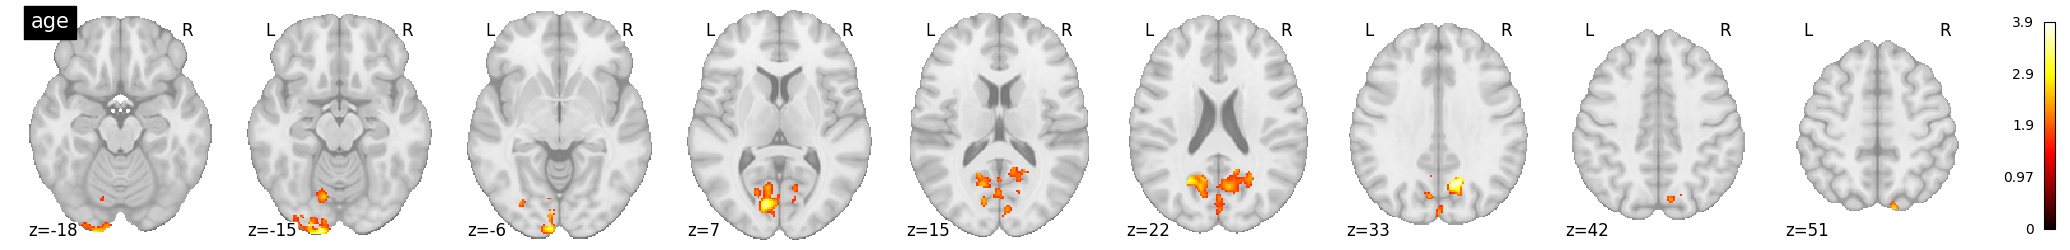

In [16]:
from nilearn import plotting, image
import matplotlib.pyplot as plt
plotting.plot_stat_map('tmp/voxelwise/thres/mapflow/_thres0/spmT_0001_thr.nii', display_mode='z', cut_coords=9, title='age')
plt.show()